In [2]:
import drawsvg as dw
from os import listdir
dir = '/home/jh/src/svg/lib'
files = listdir(dir)
for file in files:
    if file[-3:] == '.py':
        f = '%s/%s' % (dir,file)
        exec(open(f).read())

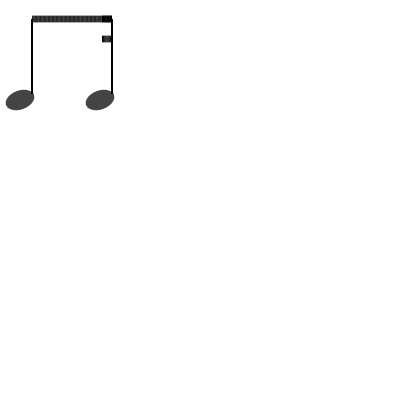

In [10]:
d = dw.Drawing(200,200)

def gruppe(notlist=[10,60,40,50,60,120],
           balken=1, dotlist=0,
           balkdick=1, balkspace=1, balklen=1,
           dirlen=1.5, y_space=10, swfac=1, swfac_head=1, c='#444', dotspace=1, dotsiz=1, fill=True,
           cp_x=0.5, cp_y_shift=0, resolution=100, cline='black', **args):
    """eine gruppe von noten unter einem oder mehreren balken.
        der balken wird als quadratische bezierkurve gezogen; der kontrollpunkt kann
        mit cp_x und cp_y_shift modifiziert werden.
    INPUT:
    notlist: liste mit x,y werten der einzelnen noten
    balken: entweder zahl für die anzahl der balken
        oder liste: wie viele balken bei jeder note (negativ = nach links)
    dotlist: entweder zahl (default 0 = keine)
        oder liste mit zahlen für punktierung jeder einzelnen note 
    balkdick: dicke der balken als relation zum y_space (1 = y_space/3)
    balkspace: abstand zwischen zwei balken als relation zur dicke (1 = dicke*2)
        entweder zahl oder liste für jede note
    balklen: länge eines einzelbalkens als relation zu y_space (1 = y-space/2)
    dirlen: wie bei not4tel; gilt für die randnoten
    cp_x: horizontale position des kontrollpunkte zwischen 0=links und 1=rechts
        default = 0.5 (mitte)
    cp_y_shift: y-verschiebung des kontrollpunkts, als faktor von abs(dirlen)
        default ist 0, dh der kontrollpunkt liegt auf der linie zwischen den beiden randnoten.
        cp_y_shift = 1 würde den kontrollpunkt um dirlen nach oben verschieben
        cp_y_shift = -1 entsprechend nach unten
    resolution: wieviele punkte für die balken (werden dann durch kleine linien verbunden)
    die übrigen parameter sind wie bei note
    fill kann True sein (dann noten gefüllt mit color), oder False (dann hohl)"""
    # input und umformungen
    sw = y_space * swfac * 0.1 
    swhead = sw*swfac_head*1.5
    dick = balkdick * y_space/3
    blen = y_space * 0.5 * balklen
    nothals = dirlen * y_space * 2.5
    # x und y shifts am notenkopf
    dir_vz = dirlen / abs(dirlen) # 1 oder -1
    xshift_head = y_space * 0.6 * dir_vz
    yshift_head = -y_space * 0.3 * dir_vz
    # balken start und ende berechnen
    xstart,ystart = notlist[0],notlist[1]
    xend,yend = notlist[-2],notlist[-1]
    xstart_balken = xstart + xshift_head
    ystart_balken = ystart + yshift_head - nothals
    xend_balken = xend + xshift_head
    yend_balken = yend + yshift_head - nothals
    # den kontrollpunkt festsetzen
    xcp = xstart_balken + (xend_balken-xstart_balken) * cp_x
    ycp = ystart_balken + (yend_balken-ystart_balken)*cp_x - cp_y_shift * abs(nothals)
    # bezierkurve
    bezier = [xstart_balken,ystart_balken,xcp,ycp,xend_balken,yend_balken]
    # die angaben für balken und dots ggf expandieren
    numnotes = round(len(notlist) / 2)
    if not isinstance(balken,list):
        balken = [balken]*numnotes
    if not isinstance(dotlist,list):
        dotlist = [dotlist]*numnotes
    if not isinstance(balkspace,list):
        bspace = [dick * balkspace * 3]*numnotes
    else:
        bspace = [dick * i * 3 for i in balkspace]
    # iterieren 
    for i in range(numnotes):
        # 1. notenköpfe, ggf punkt(e)
        xkopf,ykopf = notlist[i*2],notlist[i*2+1]
        if fill: f = c
        else: f = 'none'
        dt = dotlist[i]
        note(xkopf,ykopf,y_space,swfac=swhead,dotted=dt,c=c,dotspace=dotspace,dotsiz=dotsiz,fill=f,**args)
        # 2. hälse
        xhals = xkopf + xshift_head
        yhals_kopf = ykopf + yshift_head
        yhals_balk = getqbezier(xhals,*bezier)
        d.append(dw.Line(xhals,yhals_kopf,xhals,yhals_balk,stroke=cline,stroke_width=sw))
        # 3. balken
        balk = balken[i] # zahl insgesamt
        val = 1 # mit erstem balken (von oben) beginnen
        # balken zeichnen
        ybalkshift = [0,0]
        while val <= abs(balk):
            #   falls negativ oder letzte note, nach links ziehen
            if balk < 0 or i == numnotes-1: 
                drawqbezier(xhals-blen,xhals,*bezier,sw=dick,c=cline,yshift=ybalkshift)
            #   alles andere nur bis zur vorletzten note
            if i < numnotes-1:
                nextbalk = balken[i+1]
                nexthals = notlist[(i+1)*2] + xshift_head
                res = round((nexthals-xhals)/(xend_balken-xstart_balken) * resolution)
                if res<2: res = 2
                # durchziehen falls nächste note mindestens gleiche anzahl hat
                if abs(nextbalk) >= val: xbalk_ende = nexthals
                # kurzer balken nach rechts wenn balk positiv und nächster kleiner
                elif balk > 0 and val > abs(nextbalk): xbalk_ende = xhals + blen
                # nichts tun wenn vorige note selbe zahl hat und nächste kleiner ist
                else: xbalk_ende = xhals
                # zeichnen 
                drawqbezier(xhals,xbalk_ende,*bezier,sw=dick,c=cline,yshift=ybalkshift,resolution=res)
            # werte aktualisieren
            val += 1
            ybalkshift[0] = ybalkshift[0]+bspace[i]*dir_vz
            if i < numnotes-1: ybalkshift[1] = ybalkshift[1]+bspace[i+1]*dir_vz
            else:  ybalkshift[1] = ybalkshift[1]+bspace[i]*dir_vz


gruppe([10,50,50,50],[1,2])
    
d.set_pixel_scale(2)
#d.save_png('varVib.png')
#d.save_svg('varVib.svg')
d

In [4]:
help(gruppe)

Help on function gruppe in module __main__:

gruppe(notlist=[10, 60, 40, 50, 60, 120], balken=1, dotlist=0, balkdick=1, balkspace=1, balklen=1, dirlen=1.5, y_space=10, swfac=1, swfac_head=1, c='#444', dotspace=1, dotsiz=1, fill=True, cp_x=0.5, cp_y_shift=0, resolution=100, cline='black', **args)
    eine gruppe von noten unter einem oder mehreren balken.
        der balken wird als quadratische bezierkurve gezogen; der kontrollpunkt kann
        mit cp_x und cp_y_shift modifiziert werden.
    INPUT:
    notlist: liste mit x,y werten der einzelnen noten
    balken: entweder zahl für die anzahl der balken
        oder liste: wie viele balken bei jeder note (negativ = nach links)
    dotlist: entweder zahl (default 0 = keine)
        oder liste mit zahlen für punktierung jeder einzelnen note 
    balkdick: dicke der balken als relation zum y_space (1 = y_space/3)
    balkspace: abstand zwischen zwei balken als relation zur dicke (1 = dicke*2)
        entweder zahl oder liste für jede note